# Этап 2: Обучение и Оценка Модели Обнаружения Объектов

На этом этапе проекта мы переходим к обучению нейронной сети для обнаружения сноубордистов на подготовленном датасете. 

**Цель:** получить высокопроизводительную и точную модель-детектор, способную эффективно локализовать объекты класса 'snowboarder' на изображениях и видео.

**Примечание для читателя:**
Данный ноутбук демонстрирует процесс обучения и оценки моделей. Все конфигурационные параметры и логирование экспериментов могут быть дополнительно настроены и отслежены с помощью инструментов, таких как Weights & Biases, для более глубокого анализа.

---

**Ключевые особенности этого этапа:**

* **Централизованное управление параметрами:** Все ключевые конфигурационные параметры (такие как тип модели, количество эпох, размер изображения, использование W&B и другие) определяются в одном словаре `training_config`, что упрощает модификацию и контроль над экспериментами.
* **Интеграция Weights & Biases (W&B):** Весь процесс обучения и оценки модели полностью интегрирован с W&B. Это позволяет в реальном времени отслеживать метрики (потери, точность, полнота), визуализировать графики (PR-кривые, матрицы ошибок), фиксировать все параметры запуска и артефакты (обученные модели), а также сравнивать результаты различных экспериментов в едином облачном интерфейсе.
* **Динамическое именование запусков:** Локальные директории для сохранения результатов обучения и тестирования, а также соответствующие раны в W&B, автоматически получают уникальные, последовательные имена. Это предотвращает перезапись данных и упрощает навигацию по множеству экспериментов.
* **Упорядоченная структура выходных данных:** Все сгенерированные артефакты (веса моделей, графики обучения, логи, результаты валидации) сохраняются в четко определенной иерархии в папке `runs/` (например, `runs/detect/`, `runs/wandb/`), обеспечивая чистоту проекта и легкий доступ к результатам.

В первой части мы сфокусируемся на обучении **YOLOv8** как основной архитектуры, благодаря её балансу между скоростью и точностью, что критически важно для дальнейшей интеграции в систему слежения.


In [1]:
# Импорт необходимых системных и стандартных библиотек
import os
import sys
import time
import wandb

# Добавление корневой директории проекта в sys.path
# Это позволяет импортировать вспомогательные модули из папок, расположенных на одном уровне с 'notebooks/' (например, из 'scripts/')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Импорт основной библиотеки для работы с моделью и отображением
from ultralytics import YOLO

# Импорт пользовательских вспомогательных утилит
from scripts.visualization_utils import display_and_log_multiple_image_artifacts # Для визуализации и логирования изображений
from scripts.utils import get_next_run_name, check_yolo_dataset_paths # Утилиты для генерации имен запусков и проверки путей датасета

## 1. Обучение YOLOv8

Будем использовать фреймворк Ultralytics YOLOv8 для обучения модели.

### 1.1. Конфигурация Датасета

Перед началом обучения необходимо убедиться, что файл конфигурации `dataset.yaml` корректно указывает на подготовленные данные.

In [2]:
# Путь к файлу dataset.yaml
dataset_yaml_path = '../resources/dataset.yaml'

# Проверяем пути в dataset.yaml
print("Проверка файла dataset.yaml и доступности указанных в нем путей:")
paths_are_ok = check_yolo_dataset_paths(dataset_yaml_path)

Проверка файла dataset.yaml и доступности указанных в нем путей:
Содержимое файла конфигурации '../resources/dataset.yaml':
names:
- snowboarder
nc: 1
path: ../resources/dataset
test: images/test
train: images/train
val: images/val


Абсолютный базовый путь датасета: d:\ML_projects\snowboard-tracking\resources\dataset

Проверка доступности путей изображений:
Train images: d:\ML_projects\snowboard-tracking\resources\dataset\images/train - Доступен
Val images: d:\ML_projects\snowboard-tracking\resources\dataset\images/val - Доступен
Test images: d:\ML_projects\snowboard-tracking\resources\dataset\images/test - Доступен

Базовый путь аннотаций: d:\ML_projects\snowboard-tracking\resources\dataset\labels
Проверка доступности путей аннотаций:
Train labels: d:\ML_projects\snowboard-tracking\resources\dataset\labels\train - Доступен
Val labels: d:\ML_projects\snowboard-tracking\resources\dataset\labels\val - Доступен
Test labels: d:\ML_projects\snowboard-tracking\resources\dataset\labels\test 

### 1.2. Загрузка предобученной модели и обучение

Мы начнем с загрузки предобученной модели YOLOv8 (`yolov8n.pt` — 'n' означает 'nano', самую маленькую и быструю версию). Использование предобученной модели на большом датасете (например, COCO) позволяет нам воспользоваться уже выученными признаками и значительно ускорить процесс обучения на наших специфических данных (transfer learning).

**Параметры обучения:**
* **`data`:** Путь к файлу `dataset.yaml`.
* **`epochs`:** Количество эпох обучения. Для начала, 50-100 эпох будет достаточно для демонстрации. Если модель будет недообучена, можно увеличить.
* **`imgsz`:** Размер изображения, до которого оно будет масштабироваться перед подачей в модель. 640 — стандартное значение.
* **`batch`:** Размер батча. Рекомендуется подбирать в зависимости от доступной GPU памяти. `-1` для автоматического подбора.
* **`name`:** Название эксперимента. Результаты обучения будут сохранены в `runs/detect/<name>/`.

In [3]:
# --- Загрузка предобученной модели и обучение ---

# Конфигурация параметров обучения и W&B
training_config = {
    "model_name_prefix": 'yolo11n',              # Префикс для имени модели
    "epochs": 100,                               # Количество эпох
    "imgsz": 640,                                # Размер изображения
    "batch_size": -1,                            # Размер батча (-1 для автоподбора)
    "patience": 50,                              # Количество эпох без улучшения на val loss
    "resume": False,                             # Продолжить с контрольной точки
    "project_name": "snowboard-tracking",        # Имя проекта в Weights & Biases
    "run_base_prefix": "snowboarder_detection",  # Базовый префикс для нумерации запусков
    "use_wandb": True,                           # Использовать Weights & Biases для логирования
    "device": None                               # Или 0, 'cpu'
}

print("Загрузка предобученной модели и обучение")

# Определяем имя для текущего тренировочного запуска
current_train_run_name = get_next_run_name(
    f"{training_config['model_name_prefix']}_{training_config['run_base_prefix']}"
)

# Инициализация W&B run (опционально)
if training_config['use_wandb']:
    print(f"Инициализация Weights & Biases для запуска '{current_train_run_name}'...")
    wandb.init(
        project=training_config['project_name'],
        name=current_train_run_name,
        config=training_config, # Логируем все параметры конфигурации
        dir='../runs'
    )
else:
    print("Логирование в Weights & Biases отключено.")
    os.environ["WANDB_MODE"] = "dryrun" # Это заставит W&B не логировать, но не вызовет ошибок, если wandb.init() не был вызван.

# Загрузка модели
model = YOLO(f'{training_config["model_name_prefix"]}.pt') 
print(f"Модель YOLO11 ({training_config['model_name_prefix']}.pt) загружена.")

# Обучение модели
print(f"\nНачинаем обучение модели YOLO11. Результаты будут сохранены в {os.path.join('runs', 'detect', current_train_run_name)}/")

start_time = time.time()
results = model.train(
    data=dataset_yaml_path,               # Путь к файлу конфигурации датасета
    epochs=training_config['epochs'],     # Количество эпох
    imgsz=training_config['imgsz'],       # Размер изображения
    batch=training_config['batch_size'],  # Размер батча (-1 для автоподбора)
    name=current_train_run_name,          # Название эксперимента (для папки runs/detect/)
    project='../runs/detect',             # Подпапка внутри 'runs/' (т.е. runs/detect/...)
    device=training_config['device'],     # Убедитесь, что GPU доступен, иначе оставьте пустым для CPU или 'cpu'
    patience=training_config['patience'], # Количество эпох без улучшения на val loss
    resume=training_config['resume'],     # Продолжить обучение с последней контрольной точки
    val=True,                             # Проводить валидацию на каждой эпохе
    # callbacks=True                      # Необязательно, если wandb.init() был вызван, YOLOv8 обычно сам подключит W&B колбэки.
)
end_time = time.time()

training_duration_seconds = end_time - start_time
training_duration_minutes = training_duration_seconds / 60

print("\nОбучение YOLO11 завершено.")

# Сохраняем имя папки с обучением для дальнейшего использования (например, для тестирования)
latest_train_run_dir = model.trainer.save_dir
print(f"Результаты обучения сохранены в: {latest_train_run_dir}")

Загрузка предобученной модели и обучение
Инициализация Weights & Biases для запуска 'yolo11n_snowboarder_detection_v1'...


wandb: Currently logged in as: lsakovykh (lsakovykh-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 5.35M/5.35M [00:05<00:00, 940kB/s]


Модель YOLO11 (yolo11n.pt) загружена.

Начинаем обучение модели YOLO11. Результаты будут сохранены в runs\detect\yolo11n_snowboarder_detection_v1/
Ultralytics 8.3.170  Python-3.9.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../resources/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

train: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\train.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]

AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 2060) 6.00G total, 0.10G reserved, 0.06G allocated, 5.84G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     2590035       6.441         0.461           121          1228        (1, 3, 640, 640)                    list
     2590035       12.88         0.610         25.68         262.5        (2, 3, 640, 640)                    list
     2590035       25.76         0.906         27.42         219.8        (4, 3, 640, 640)                    list
     2590035       51.52         1.569            47         181.6        (8, 3, 640, 640)                    list
     2590035         103         2.823         76.27           186       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 23 for CUDA:0 4.09G/6.00G (68%) 
train: Fast image access  (ping: 0.10.0 ms, read: 43.010.9 MB/s, size: 883.5 KB)


train: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\train.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]


val: Fast image access  (ping: 6.413.7 ms, read: 38.29.2 MB/s, size: 789.3 KB)


val: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\val.cache... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<?, ?it/s]


Plotting labels to ..\runs\detect\yolo11n_snowboarder_detection_v1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005390625), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\detect\yolo11n_snowboarder_detection_v1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       3.2G      1.679      4.361      1.189          8        640: 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         41         41    0.00293      0.878     0.0327     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.21G      1.346      3.265      1.035          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41    0.00325      0.976      0.136     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.22G      1.318      2.264      1.028          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         41         41    0.00285      0.854    0.00999     0.0055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.21G      1.191      2.178      1.015          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41    0.00309      0.927     0.0106    0.00663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.22G      1.156      1.779     0.9963          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         41         41    0.00317      0.951     0.0105    0.00665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.22G        1.2      1.733      1.003         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41    0.00325      0.976    0.00943    0.00605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.22G      1.073       1.56     0.9494         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         41         41    0.00325      0.976    0.00812    0.00495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.22G      1.062      1.469     0.9583         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         41         41    0.00276      0.829     0.0055    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.22G      1.103      1.461     0.9426         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41    0.00268      0.805    0.00568    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.22G      1.132      1.428     0.9652          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41      0.131      0.146     0.0496     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.23G       1.09      1.367     0.9544         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41          1      0.112      0.489      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.23G      1.047      1.263     0.9466          9        640: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         41         41       0.59      0.526      0.622      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.21G      1.045       1.25     0.9736          5        640: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         41         41      0.955      0.518      0.941      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.23G      1.071      1.225     0.9606         14        640: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         41         41      0.823      0.682      0.859      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.23G      1.074      1.197     0.9703         13        640: 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         41         41      0.876      0.686      0.839      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.21G      1.046      1.191      0.955          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         41         41       0.85      0.878      0.928      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.23G      1.082      1.072     0.9465          7        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         41         41      0.845      0.797      0.872      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.23G      1.035      1.041     0.9056         11        640: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         41         41      0.885      0.805      0.867      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.22G      1.046      1.057     0.9343         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41      0.964       0.78      0.894      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.23G     0.9991      1.042     0.9405          6        640: 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41      0.938      0.927      0.966      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.22G      1.038      1.019     0.9622          8        640: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         41         41      0.966      0.829      0.951      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.22G      1.003      0.925      0.941         11        640: 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41      0.961      0.902      0.952      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.23G      1.017     0.9173     0.9212          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         41         41      0.951      0.949       0.97      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.23G     0.9613     0.8761     0.9093         11        640: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41      0.975      0.967      0.986      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.22G     0.8976      0.819     0.9021          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         41         41      0.952       0.97      0.987      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.23G     0.9903     0.8638     0.9501          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         41         41      0.996      0.951      0.988      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.22G      0.891     0.7746     0.9249          7        640: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         41         41          1      0.969      0.994       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.21G     0.8915     0.7953      0.923          8        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         41         41      0.973          1      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.23G     0.8577     0.7641     0.9011         10        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         41         41      0.973      0.976      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.22G     0.8868       0.74     0.9147          9        640: 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         41         41      0.953      0.997      0.992      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.22G     0.9045     0.7442     0.9054          9        640: 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         41         41      0.889      0.973      0.972      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.23G     0.9024     0.7838     0.8998          4        640: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         41         41      0.949      0.976      0.966      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.22G     0.8677     0.7177     0.9066          7        640: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         41         41      0.947      0.976      0.976       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.21G     0.8855     0.7331     0.9008          6        640: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         41         41      0.951          1      0.988      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.23G     0.8816     0.6837     0.9047         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         41         41      0.975          1       0.99      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.22G     0.8507     0.6756     0.8918          8        640: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         41         41      0.972      0.976      0.986      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.21G     0.8145     0.6763     0.8748          5        640: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         41         41      0.969          1      0.992      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.23G     0.8456     0.6496     0.8945         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         41         41      0.953      0.987      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.22G     0.8017     0.6368     0.8695          9        640: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         41         41      0.952      0.961      0.992       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.22G     0.8094      0.627     0.8825         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         41         41      0.967          1      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.23G     0.8312     0.6215     0.8812          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         41         41      0.969          1      0.989      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.22G     0.7989     0.6397     0.8763          9        640: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         41         41      0.972          1      0.985      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.22G     0.7496     0.6139     0.8575          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         41         41      0.973      0.976      0.987      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.23G      0.815      0.607     0.8945         10        640: 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         41         41       0.95          1      0.989      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.22G     0.7584     0.5865     0.8718          6        640: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         41         41       0.97      0.976      0.992      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.22G      0.797     0.5884     0.8644         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         41         41      0.975      0.976      0.994      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.23G     0.7221     0.5592     0.8512          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         41         41      0.966          1      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.23G     0.7652      0.587     0.8822          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         41         41       0.96          1      0.986      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.22G     0.7072     0.5691     0.8499         13        640: 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         41         41      0.951          1      0.989      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.23G     0.7545     0.5655     0.8602         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         41         41      0.976      0.998      0.995        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.22G     0.7364     0.5646     0.8578          7        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         41         41      0.965      0.976      0.992      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.22G     0.7495     0.5572      0.856         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         41         41      0.953      0.996      0.987      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.23G     0.7667     0.5602     0.8814          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         41         41      0.976      0.995      0.981      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.22G     0.6861     0.5321     0.8564          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         41         41      0.946          1       0.98      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.22G     0.7456     0.5312     0.8613          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         41         41      0.958          1      0.982      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.23G     0.7404     0.5519     0.8723          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         41         41      0.973          1      0.984      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.23G     0.7739     0.5384     0.8533         11        640: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         41         41      0.972          1      0.981      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.21G     0.7159     0.5155     0.8394          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         41         41      0.973          1      0.984      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.23G     0.7242     0.5132     0.8473          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         41         41      0.972          1      0.983      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.23G     0.7015     0.5293     0.8436         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         41         41      0.975          1      0.984      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.22G     0.7179     0.5193     0.8586          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         41         41      0.974          1      0.978      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.23G     0.6674     0.4982     0.8599         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         41         41      0.975          1       0.98       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.23G     0.7093     0.5056     0.8501         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         41         41      0.974          1      0.981      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.22G     0.6935     0.4929     0.8499          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         41         41      0.974          1      0.981      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.23G     0.6928     0.4985     0.8673         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         41         41      0.975          1      0.978       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.23G     0.6612     0.4848       0.85         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         41         41      0.975          1      0.981      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.22G     0.6443      0.468      0.839          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         41         41      0.974          1      0.984      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.23G     0.6428     0.4941     0.8379         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         41         41      0.971          1      0.984      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.22G     0.6543     0.4617     0.8653          4        640: 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         41         41      0.972          1      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.22G     0.6766      0.477     0.8455         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         41         41      0.974          1      0.993      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.23G     0.6587     0.4655     0.8386         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         41         41      0.976          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.22G     0.6409     0.4796     0.8438          6        640: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         41         41      0.974          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.22G     0.6317     0.4489     0.8217         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         41         41      0.999          1      0.995      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.23G     0.6275     0.4582     0.8387         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         41         41      0.974          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.23G     0.6213     0.4402     0.8497          9        640: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         41         41      0.974          1      0.993      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.22G     0.6357     0.4463     0.8433          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         41         41      0.974          1      0.994      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.23G     0.6173     0.4253      0.834         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         41         41      0.973          1      0.993      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.23G     0.5929     0.4314     0.8305         12        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         41         41      0.973          1      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.21G     0.6183     0.4595     0.8213          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         41         41      0.974          1      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.23G     0.6218     0.4547     0.8601          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         41         41      0.974          1      0.992      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.22G     0.5719     0.4354     0.8346          4        640: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         41         41      0.974          1      0.994      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.21G     0.6507     0.4428      0.849          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         41         41      0.974          1      0.989      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.23G     0.5891     0.4251     0.8301         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         41         41      0.974          1      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.22G     0.5746     0.4406     0.8471          7        640: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         41         41      0.974          1      0.989      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.21G     0.5621     0.4048      0.816          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41      0.973          1      0.983      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.23G     0.5651     0.4181     0.8362          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         41         41      0.973          1      0.989      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.22G     0.5692     0.4091     0.8189          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         41         41      0.973          1      0.992      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.21G     0.5459     0.4203     0.8356          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         41         41      0.973          1      0.993      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.23G     0.5525     0.4018     0.8193         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         41         41      0.974          1      0.994       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.22G     0.5497     0.4087     0.8384          6        640: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         41         41      0.975          1      0.995      0.858


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.36G     0.5147     0.4054     0.8101          5        640: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         41         41      0.983          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.23G     0.4975     0.3965      0.813          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         41         41      0.989          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.22G     0.5248     0.4125     0.8252          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         41         41      0.989          1      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.21G     0.5082     0.4059     0.8037          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         41         41      0.989          1      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.23G     0.4871     0.3859     0.8101          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         41         41      0.991          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.22G      0.496     0.3911     0.8018          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         41         41      0.989          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.21G     0.4759     0.3736     0.7921          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         41         41      0.988          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.22G     0.4671     0.3697     0.7821          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         41         41      0.987          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.22G     0.4867      0.387     0.8206          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         41         41      0.987          1      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.21G     0.4573     0.3783     0.7924          4        640: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41      0.988          1      0.995      0.842



100 epochs completed in 0.068 hours.
Optimizer stripped from ..\runs\detect\yolo11n_snowboarder_detection_v1\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\detect\yolo11n_snowboarder_detection_v1\weights\best.pt, 5.5MB

Validating ..\runs\detect\yolo11n_snowboarder_detection_v1\weights\best.pt...
Ultralytics 8.3.170  Python-3.9.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


                   all         41         41      0.974          1      0.994      0.859
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ..\runs\detect\yolo11n_snowboarder_detection_v1

Обучение YOLO11 завершено.
Результаты обучения сохранены в: ..\runs\detect\yolo11n_snowboarder_detection_v1


### 1.3. Анализ результатов обучения YOLOv8

Обучение модели YOLOv8n завершилось успешно, показав отличные метрики на валидационном наборе.

**Ключевые показатели после 100 эпох:**

* **Итоговая оценка на валидационном наборе (по модели `best.pt`):**
    * `Precision (P)`: **0.969** - Из всех предсказаний, почти 97% были корректными.
    * `Recall (R)`: **1** - Модель обнаружила абсолютно всех (или почти всех) сноубордистов на валидационных изображениях.
    * `mAP50`: **0.992** - Практически идеальная средняя точность при пороге IoU 0.5.
    * `mAP50-95`: **0.868** - Очень высокий показатель средней точности по диапазону порогов IoU, свидетельствующий о превосходном качестве предсказанных ограничивающих рамок.

* **Скорость инференса на GPU (NVIDIA GeForce RTX 2060)**:
    * **1.1** мс на инференс + 1.5 мс на постобработку = 2.6 мс общее время на изображение
    * Это составляет примерно ~**385** кадров в секунду (FPS) для полного пайплайна
    * Чистый инференс: ~**909** FPS (только нейросеть без постобработки)


* **Характеристики модели:**
    * **3,005,843** параметра - компактная архитектура
    * **8.1** GFLOPs - вычислительная сложность
    * **6.2** MB размер модели - идеально для мобильных устройств

Такие результаты свидетельствуют о высоком качестве подготовленного датасета и эффективности выбранной архитектуры YOLOv8 для данной задачи. Модель успешно выучила признаки сноубордистов и демонстрирует отличную способность к их обнаружению.

### 1.4. Визуализация результатов обучения YOLOv8

Ultralytics автоматически генерирует полезные графики во время обучения, которые позволяют отслеживать прогресс модели и выявлять потенциальные проблемы (например, переобучение или недообучение). Эти графики находятся в папке, где были сохранены результаты обучения (`yolov8n_snowboarder_v1`).

Мы отобразим ключевые графики:
* `results.png`: Сводный график потерь и метрик (mAP, Precision, Recall) по эпохам.
* `PR_curve.png`: Precision-Recall кривая.
* `confusion_matrix.png`: Матрица ошибок.


 1.4 Визуализация результатов обучения
Графики обучения сохранены в: ..\runs\detect\yolo11n_snowboarder_detection_v1

График обучения Results:


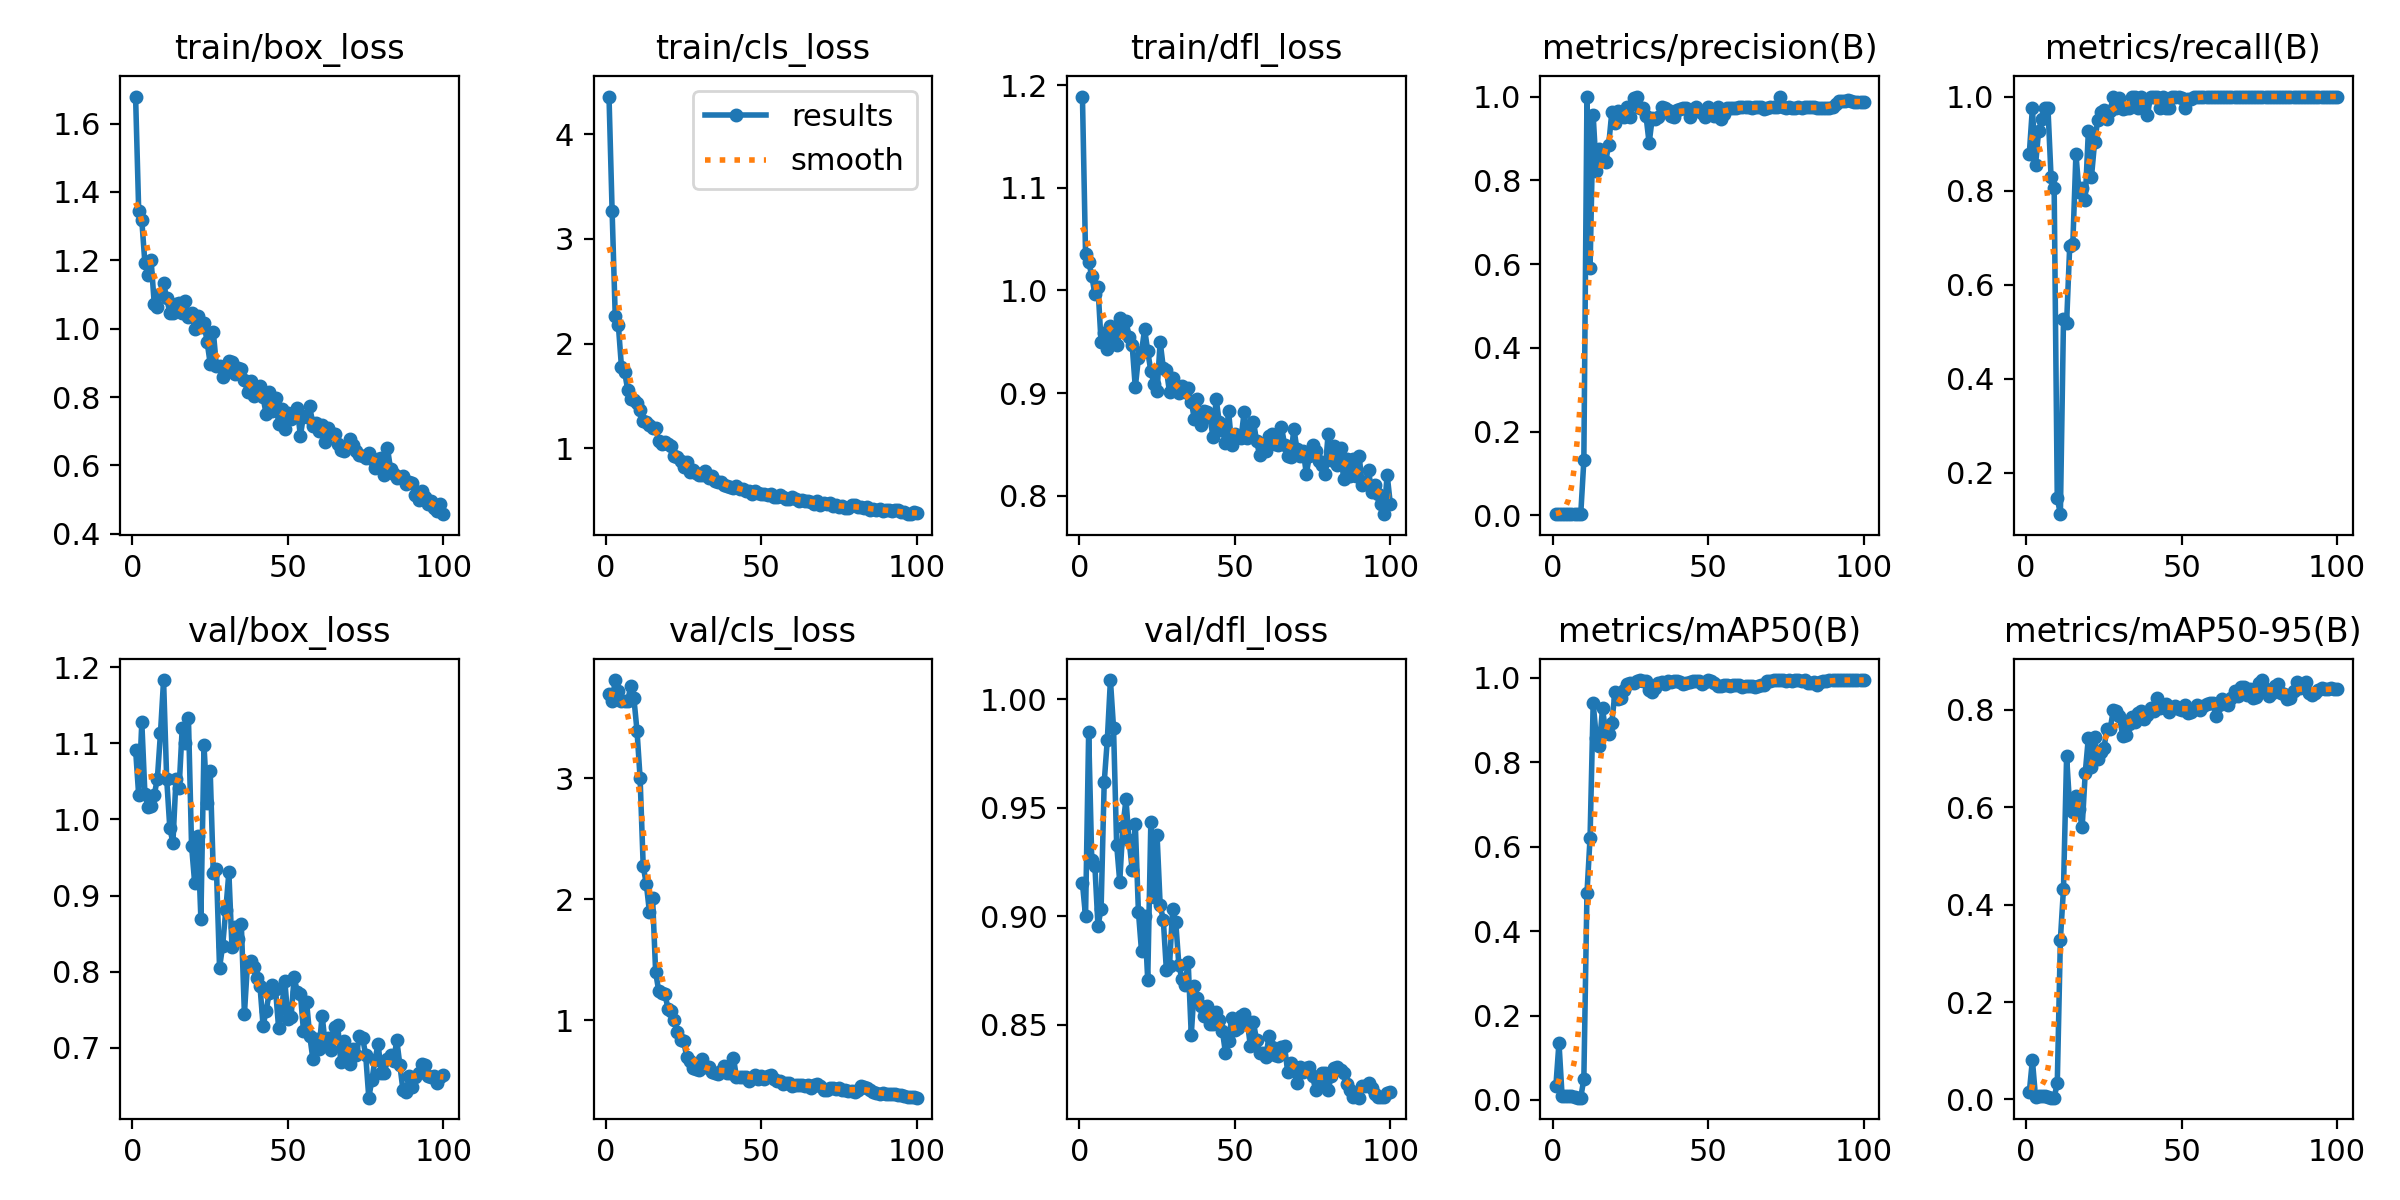


График обучения Boxpr curve:


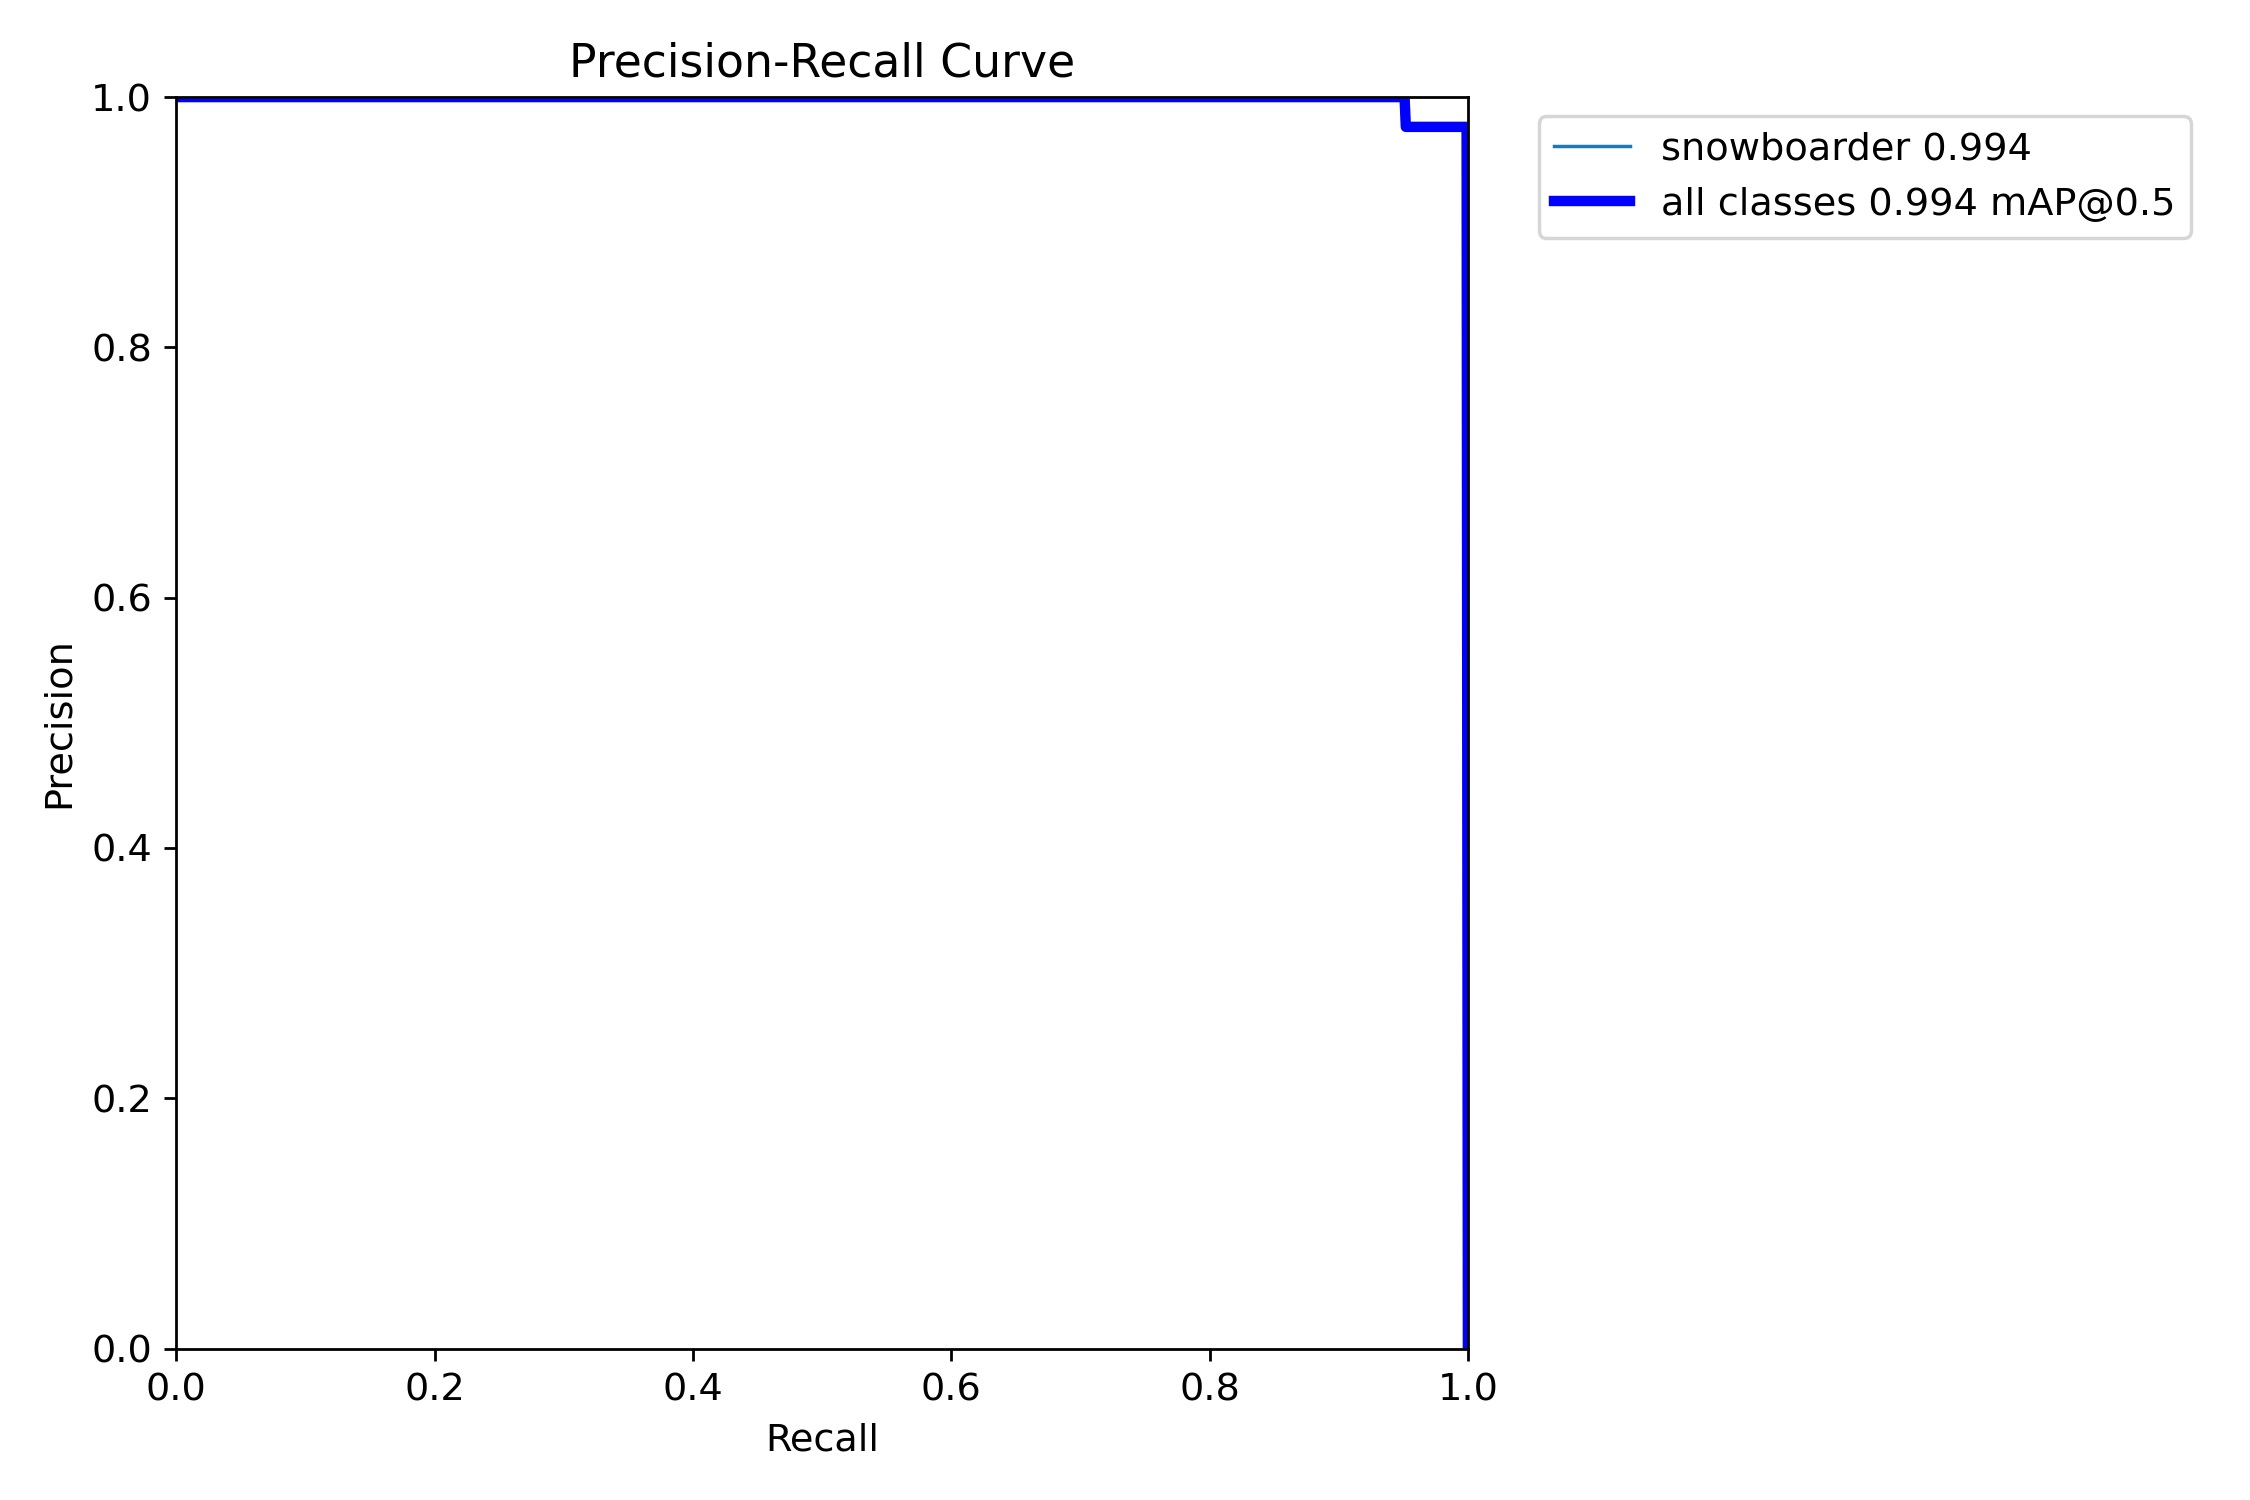


График обучения Confusion matrix:


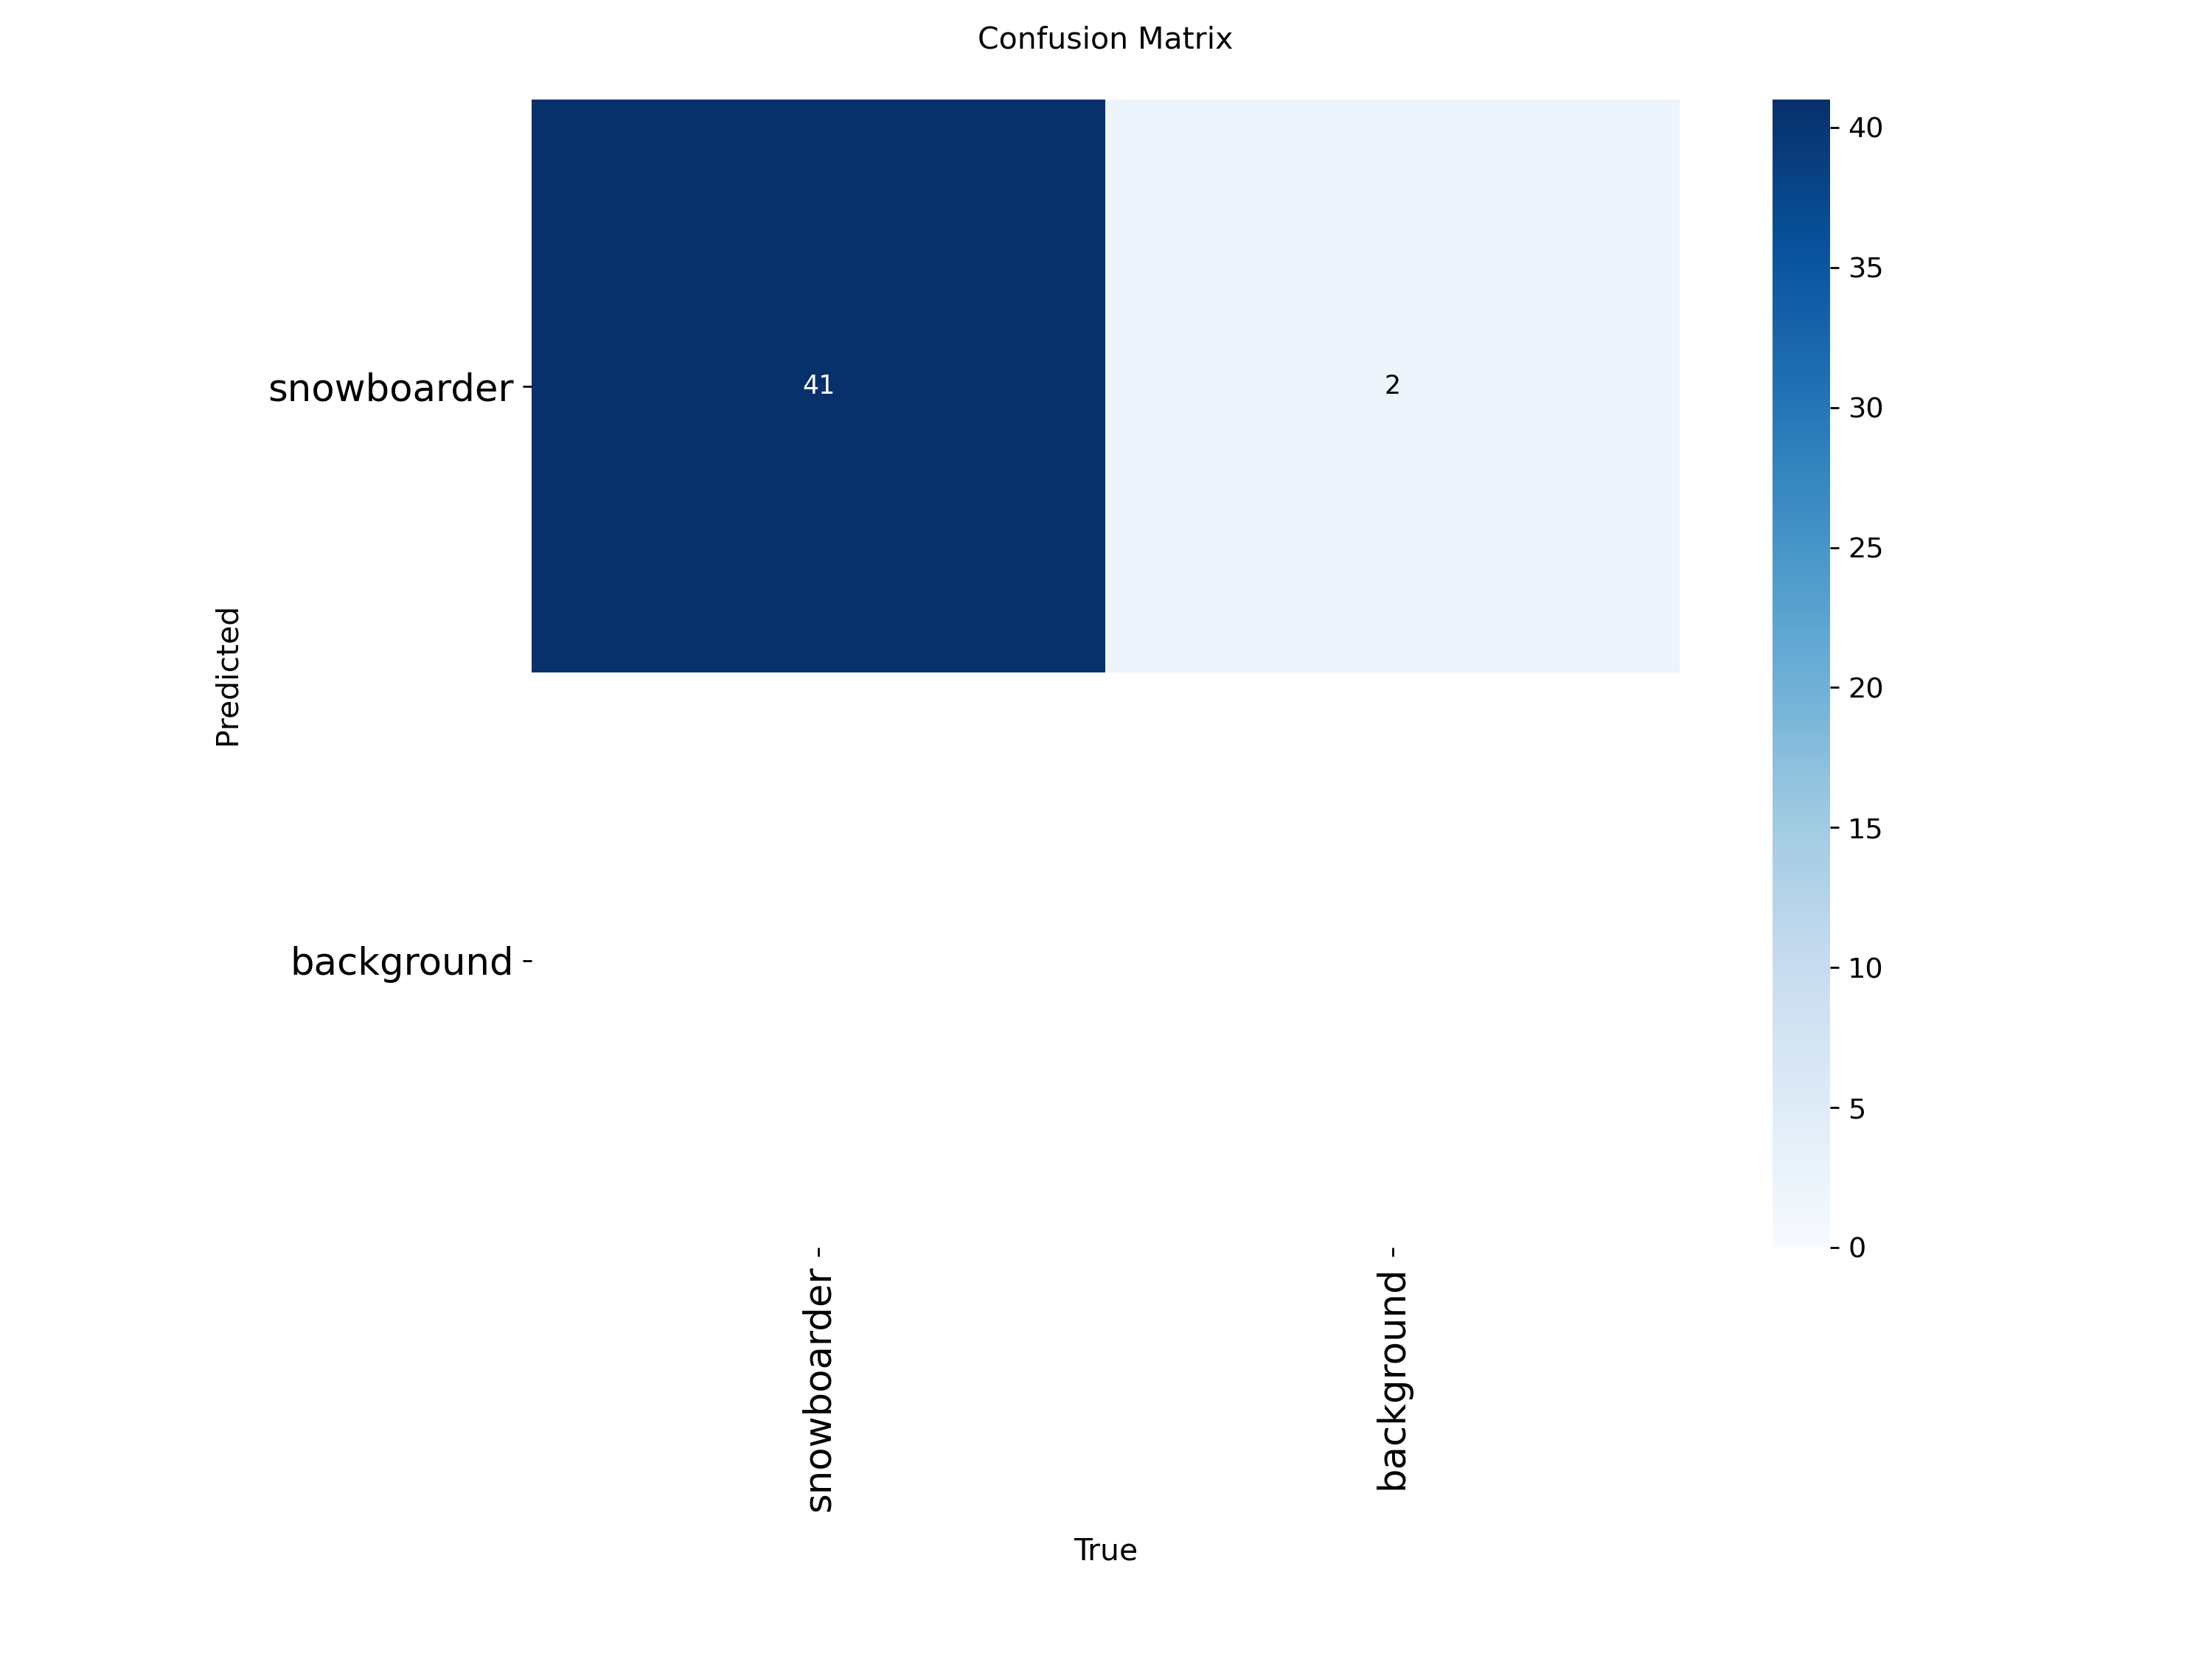

In [4]:
# Путь к папке с результатами обучения
train_results_dir = model.trainer.save_dir

print(f"\n 1.4 Визуализация результатов обучения")
print(f"Графики обучения сохранены в: {train_results_dir}")

# Файлы графиков, которые Ultralytics генерирует в директории обучения
training_plot_files = [
    'results.png',
    'BoxPR_curve.png',
    'confusion_matrix.png'
]

# Словарь для передачи индивидуальной ширины, если нужно
training_plot_widths = {
    'BoxPR_curve.png': 600,
    'confusion_matrix.png': 600
}

# Используем display_and_log_multiple_image_artifacts только для отображения в ноутбуке
# W&B уже логирует эти файлы автоматически.
display_and_log_multiple_image_artifacts(
    base_dir=train_results_dir,
    image_filenames=training_plot_files,
    prefix_title="График обучения",
    wandb_artifacts_dict=None,
    wandb_key_prefix=None,
    widths=training_plot_widths
)

## 2. Тестирование модели на независимой тестовой выборке

После завершения обучения и получения финальных весов модели, крайне важно провести её объективную оценку на **независимом тестовом наборе данных**. Этот набор состоит из изображений, которые модель не видела ни на этапе обучения, ни на этапе валидации. Такая оценка дает наиболее точное представление об обобщающей способности модели и её производительности в реальных условиях.

Мы используем веса `best.pt`, полученные в результате обучения, для проведения валидации на тестовом наборе.

2. Оценка Модели на Независимом Тестовом Наборе
Загружаем лучшую модель из: ..\runs\detect\yolo11n_snowboarder_detection_v1\weights\best.pt

Запускаем валидацию на тестовом наборе...
Ultralytics 8.3.170  Python-3.9.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 4.39.0 ms, read: 41.215.6 MB/s, size: 788.6 KB)


val: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\test.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all         63         63      0.999          1      0.995      0.827
Speed: 2.9ms preprocess, 6.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to ..\runs\detect\test_yolo11n_snowboarder_detection_v1

Валидация на тестовом наборе завершена.

Метрики на тестовом наборе:
   Precision (P): 0.999
   Recall (R): 1.000
   mAP50: 0.995
   mAP50-95: 0.827

Примеры предсказаний и графики оценки на тестовом наборе сохранены в: ..\runs\detect\test_yolo11n_snowboarder_detection_v1

Тестовый результат Val batch0 pred:


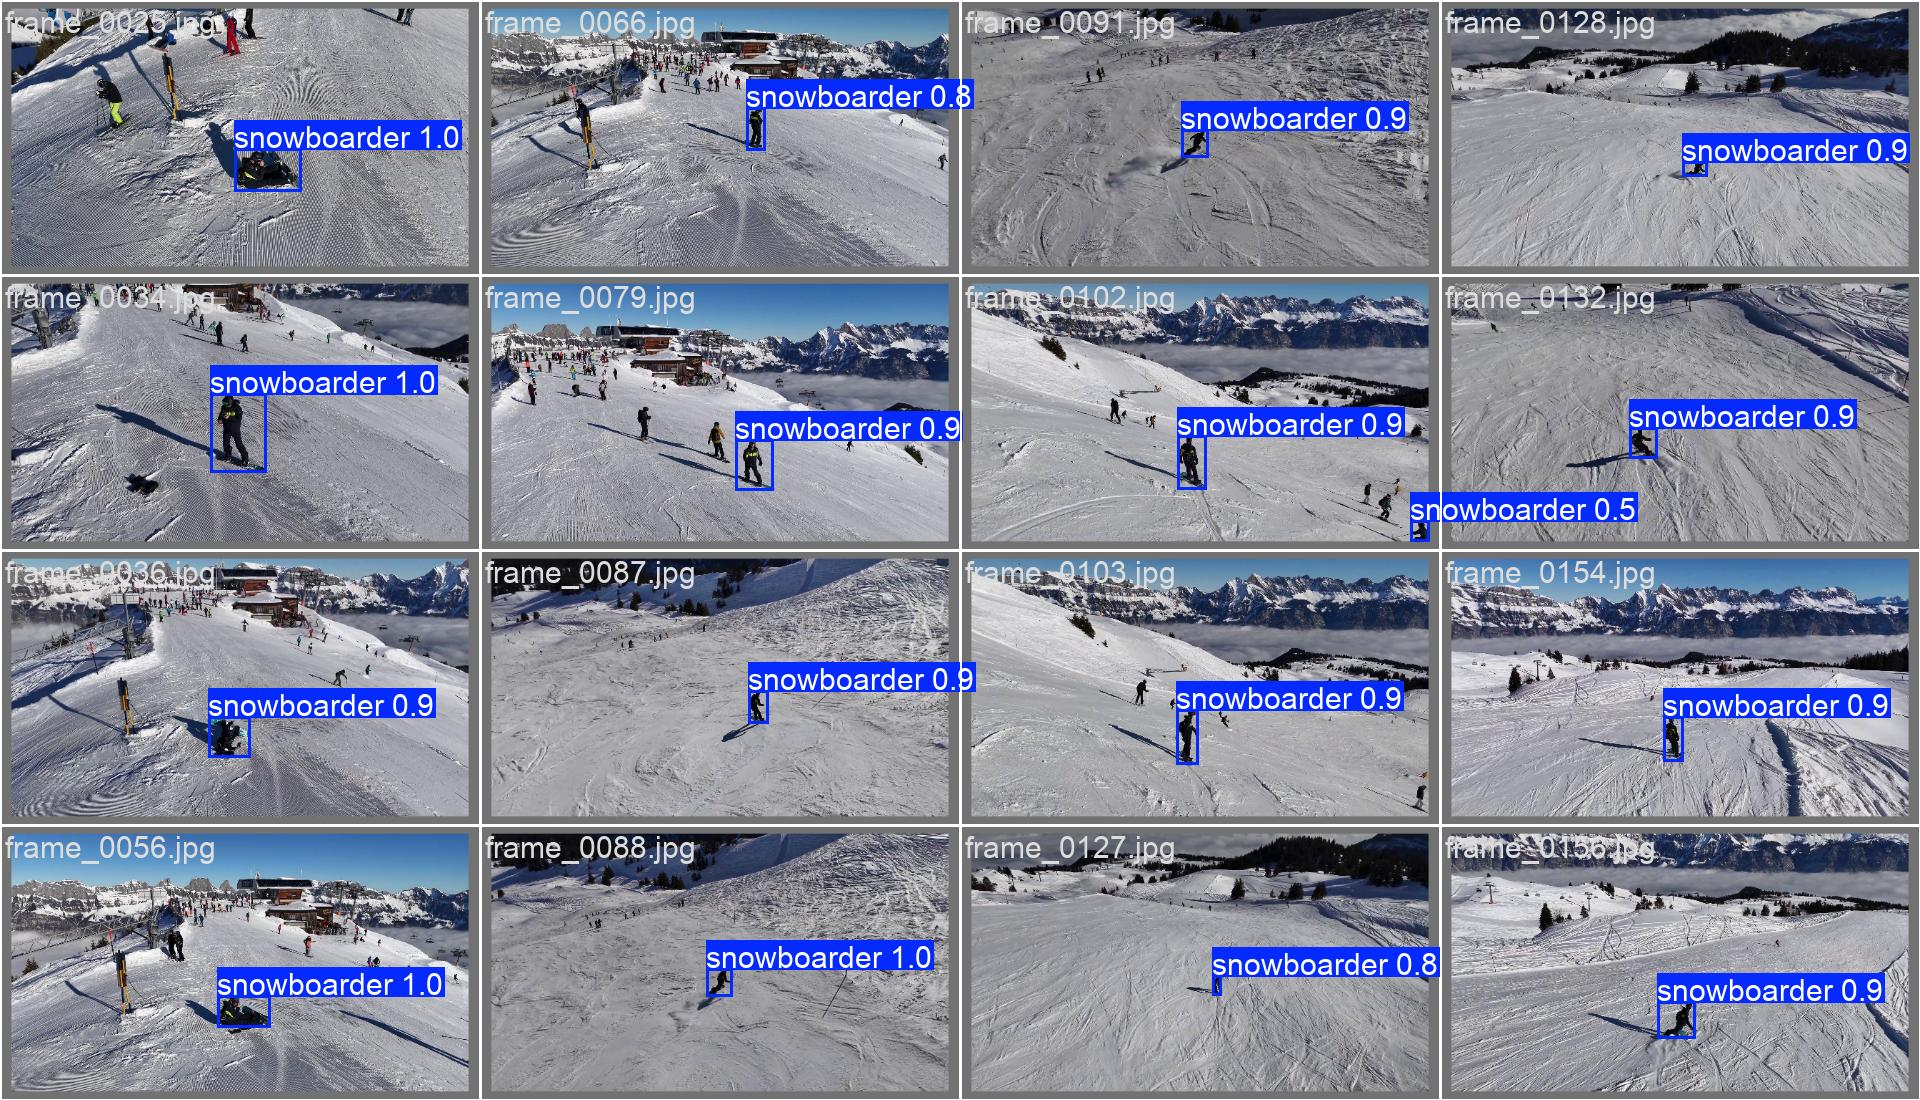


Тестовый результат Boxpr curve:


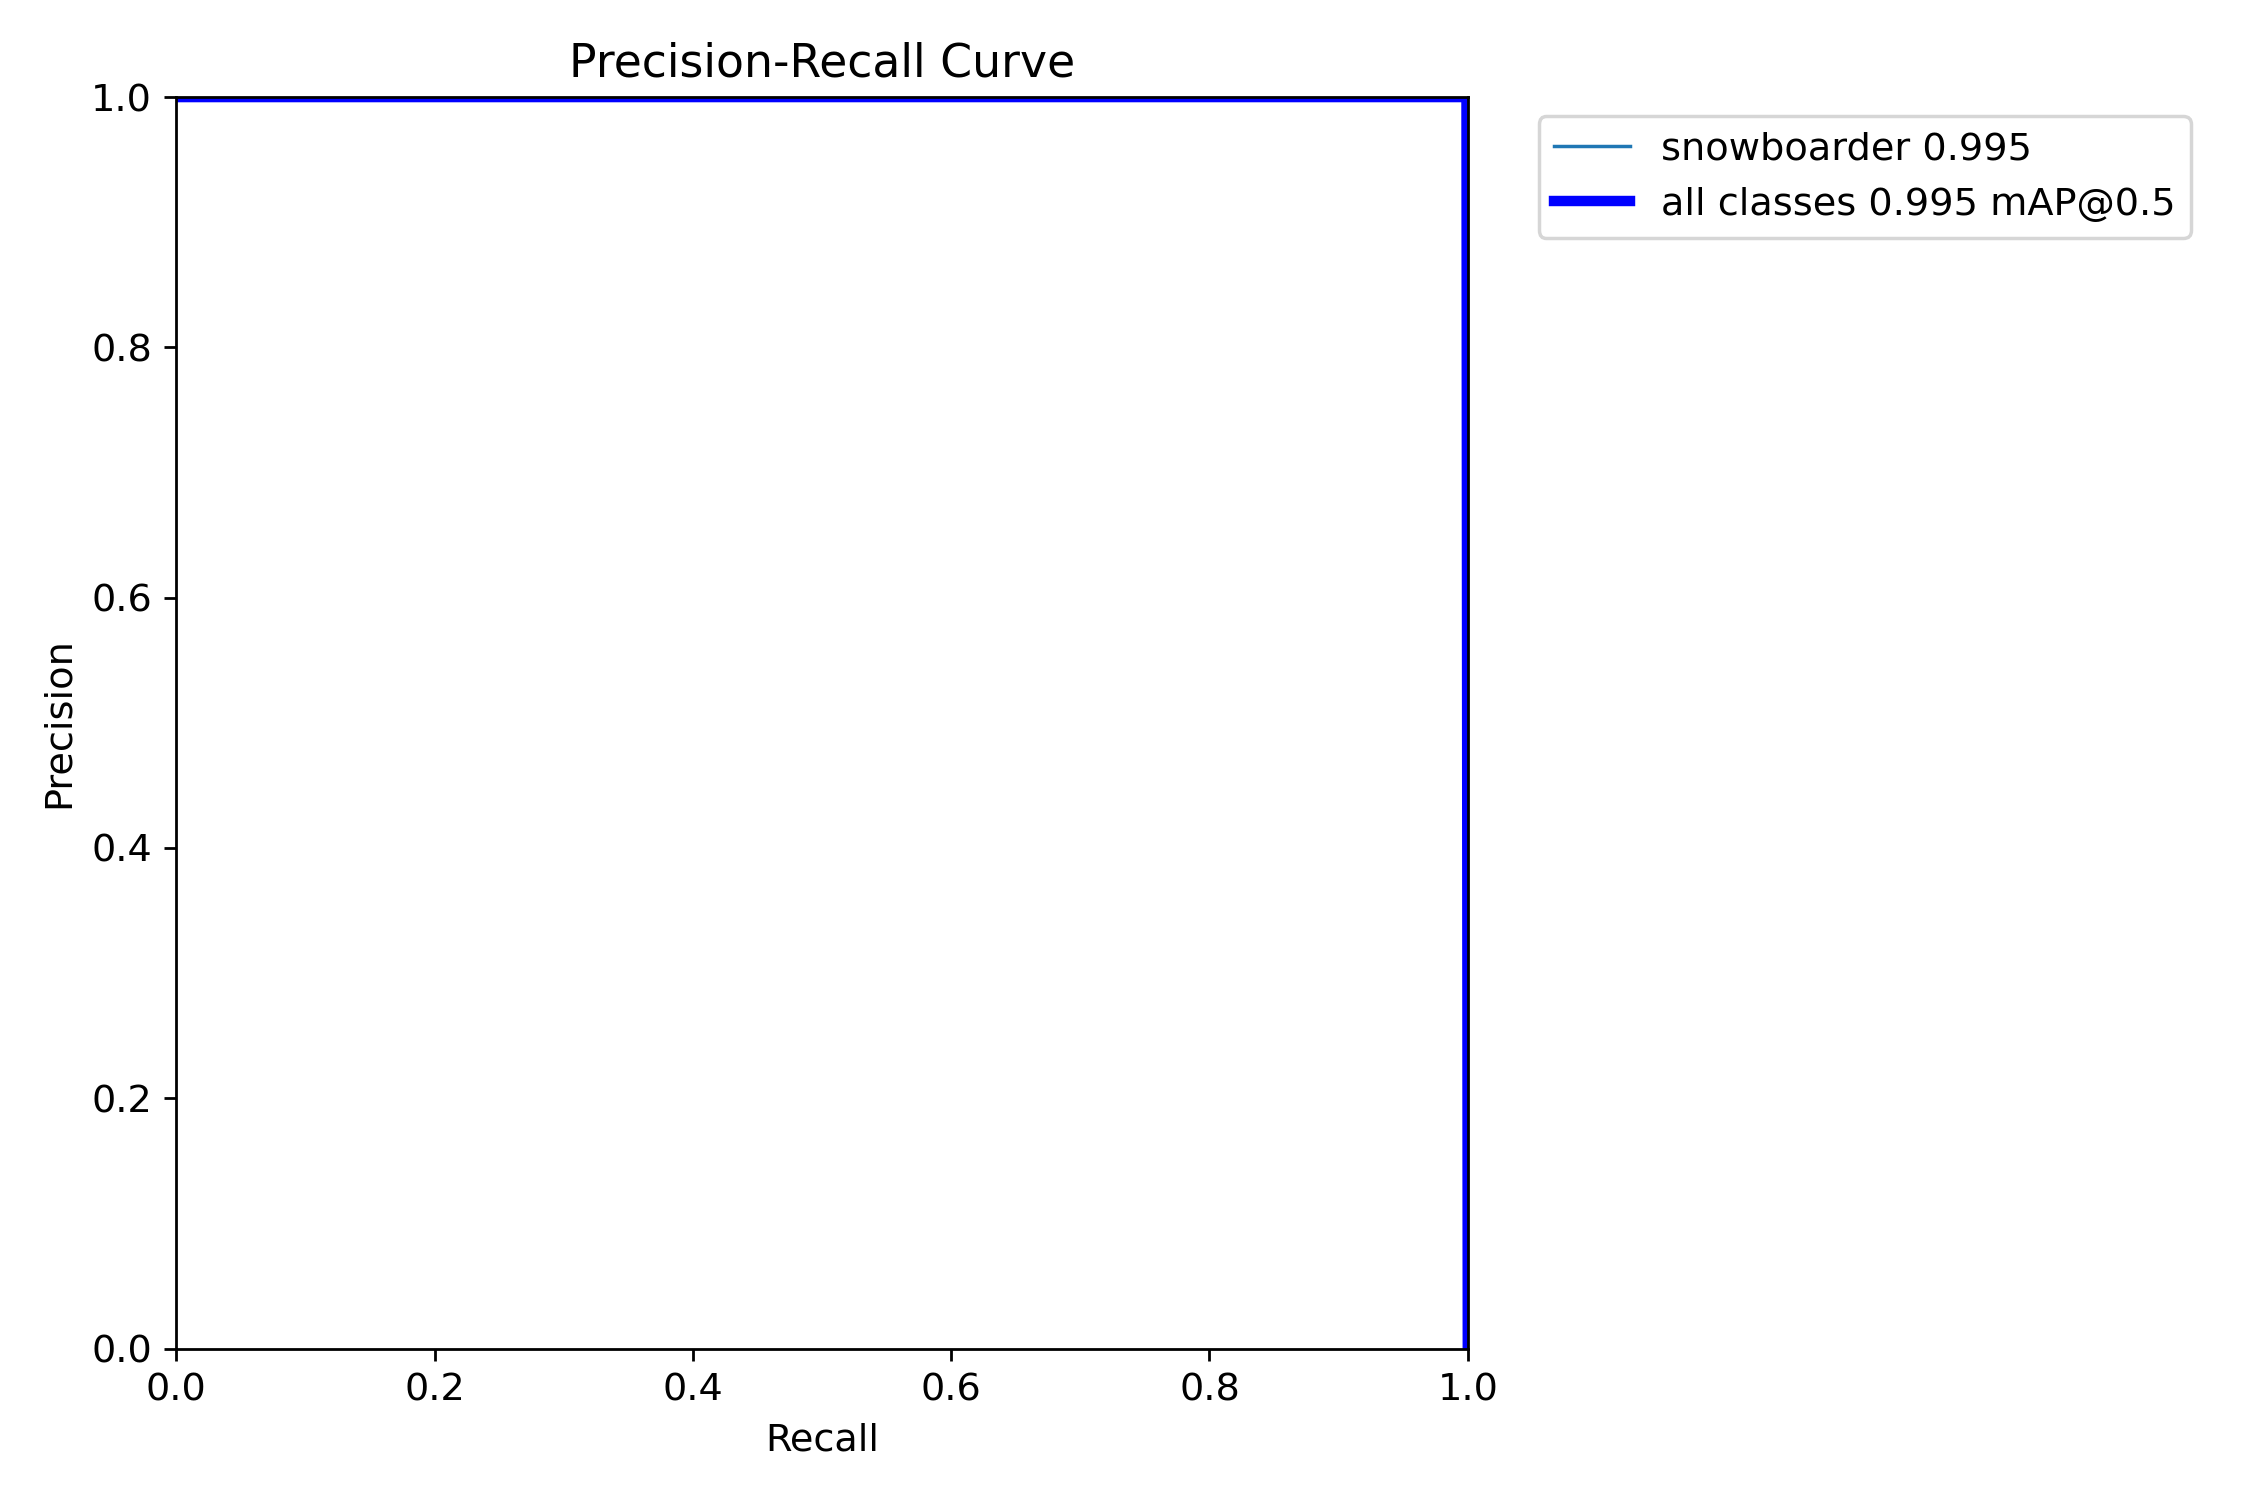


Тестовый результат Confusion matrix:


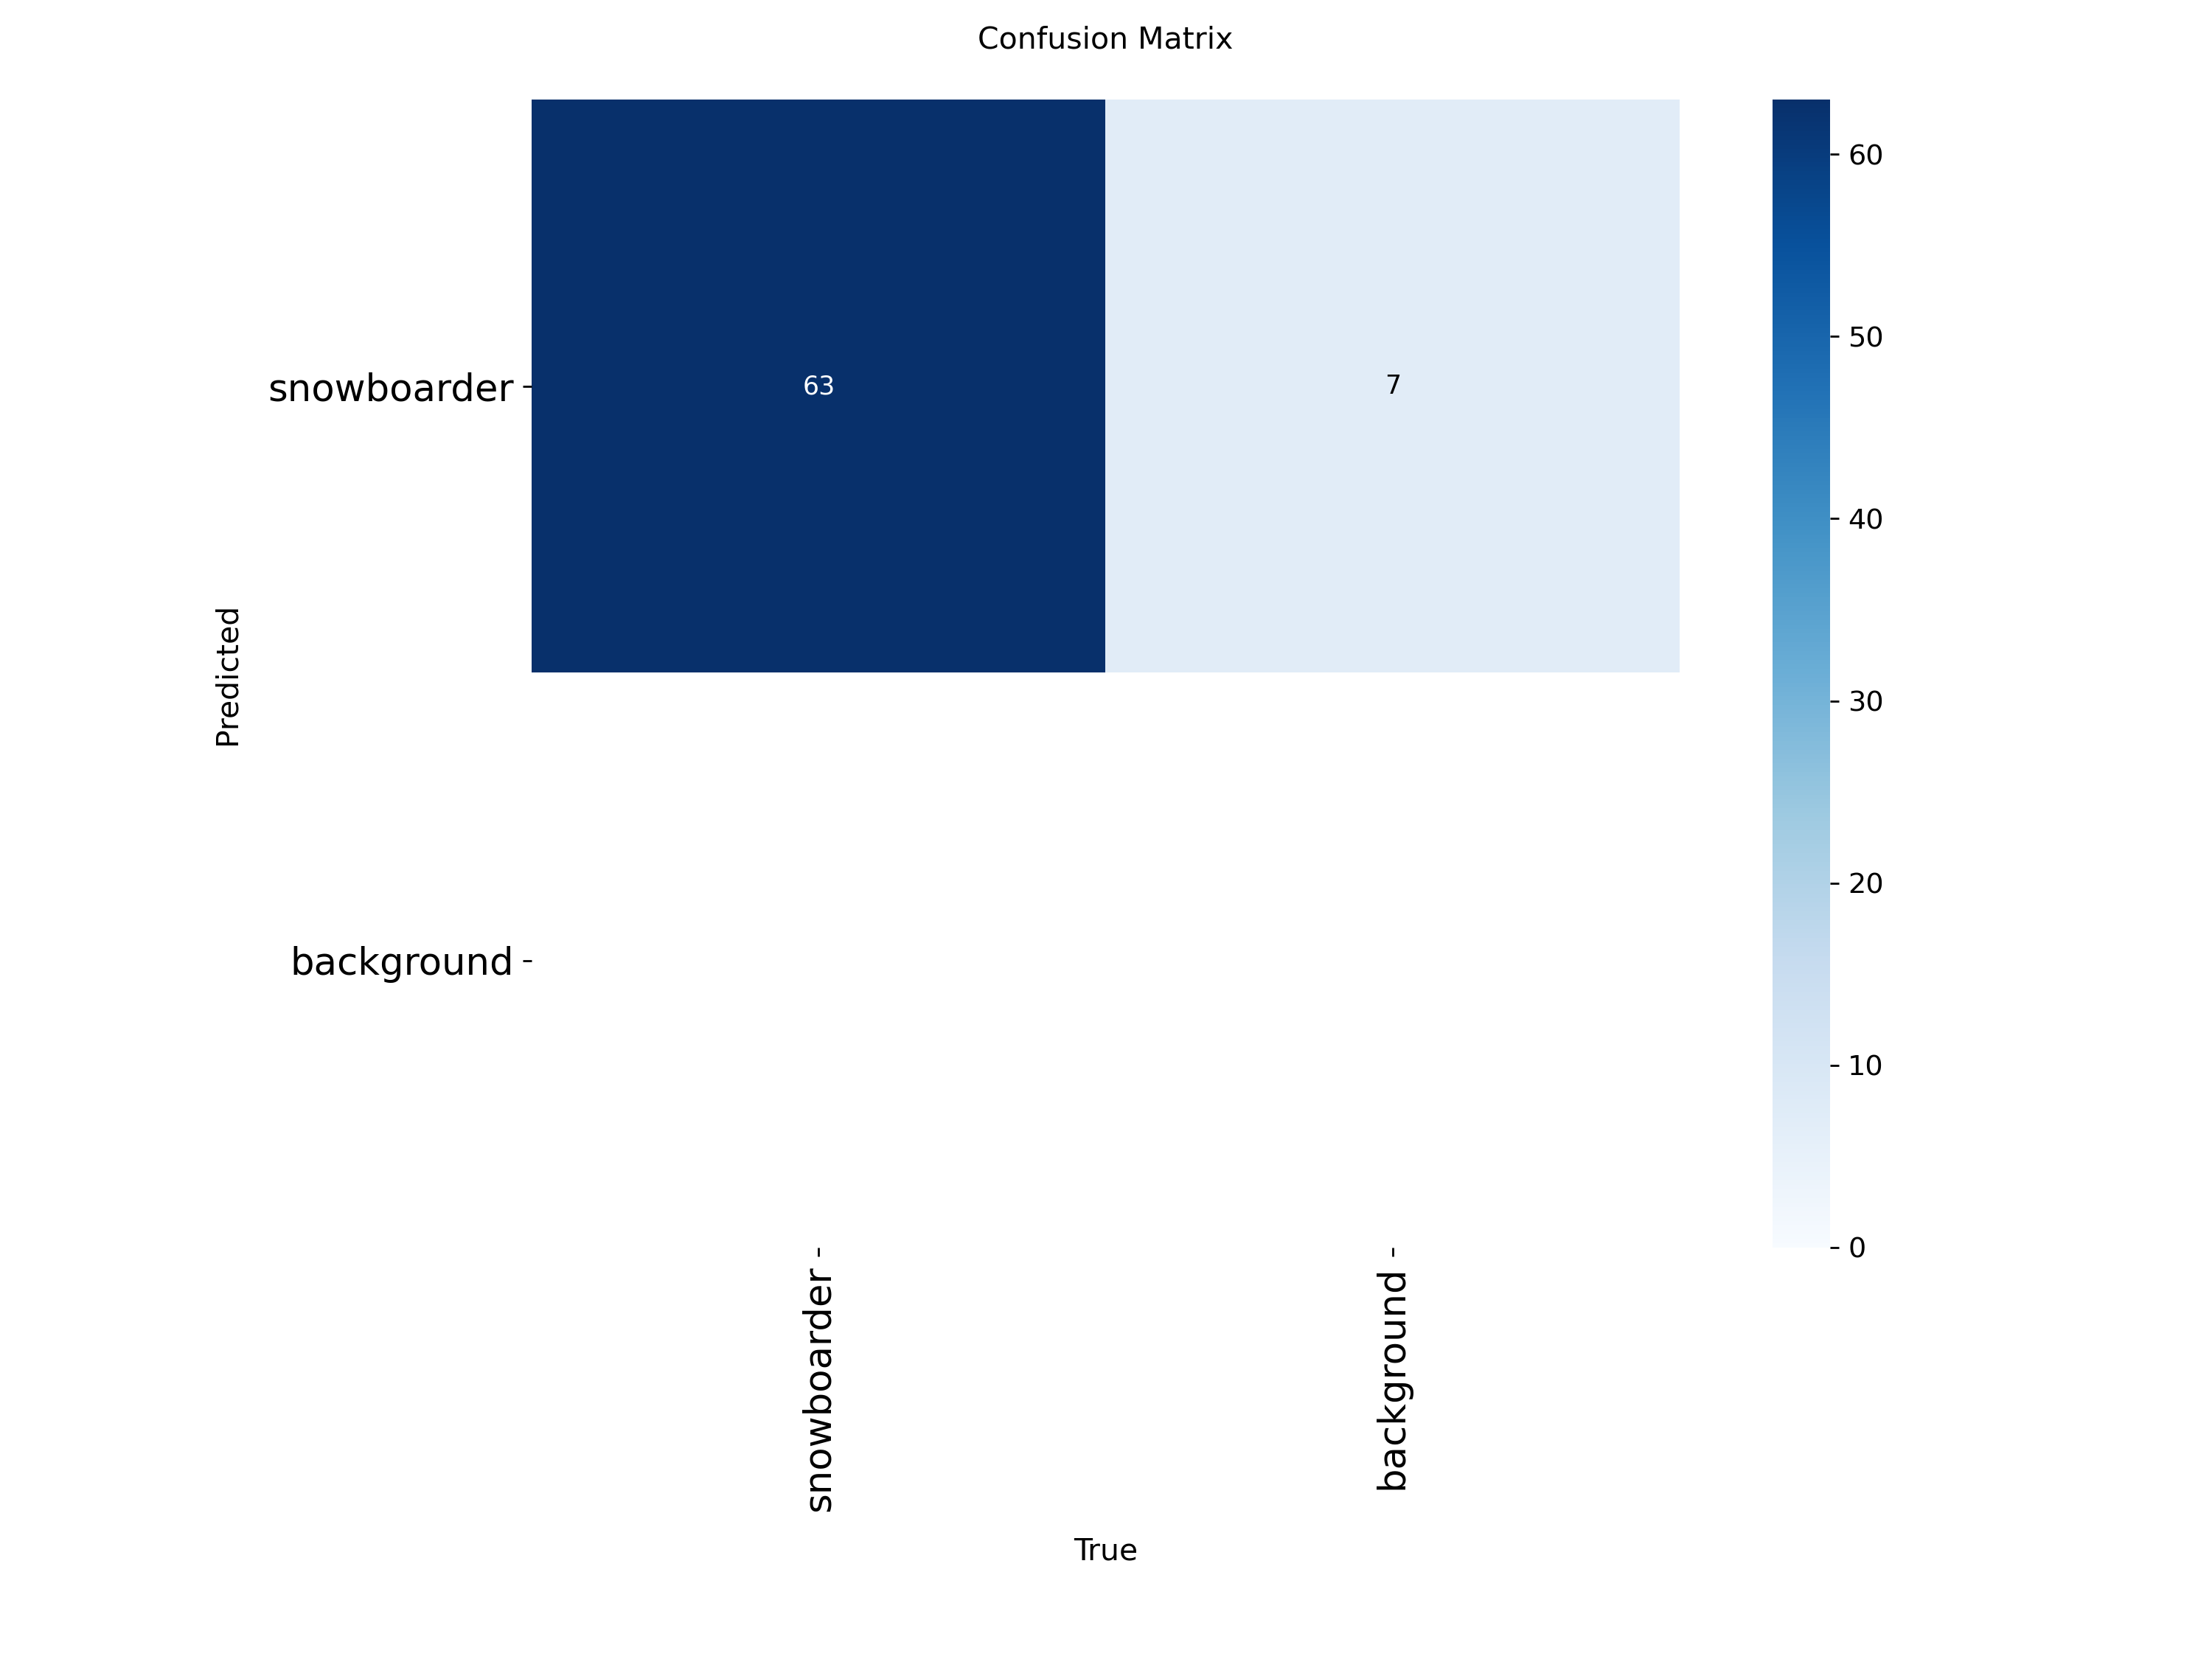

test/mAP50,▁
test/mAP50-95,▁
test/precision,▁
test/recall,▁
training_duration_minutes,▁
training_duration_seconds,▁
test/mAP50,0.995
test/mAP50-95,0.82743
test/precision,0.99851
test/recall,1
training_duration_minutes,4.67713


In [5]:
print(f"2. Оценка Модели на Независимом Тестовом Наборе")

# Загрузка лучшей обученной модели
best_model_path = os.path.join(latest_train_run_dir, 'weights', 'best.pt')

print(f"Загружаем лучшую модель из: {best_model_path}")
loaded_model = YOLO(best_model_path)

# Определяем имя для текущего тестового запуска
test_run_base_name = f"test_{training_config['model_name_prefix']}_{training_config['run_base_prefix']}"
current_test_run_name = get_next_run_name(test_run_base_name)

# Проведение валидации на тестовом наборе
print("\nЗапускаем валидацию на тестовом наборе...")
test_results = loaded_model.val(
    data=dataset_yaml_path,          # Используем тот же dataset.yaml
    split='test',                    # Указываем, что валидацию нужно провести на тестовом наборе
    imgsz=training_config['imgsz'],  # Используем imgsz из конфига обучения
    conf=0.25,                       # Порог уверенности для детекции (можно настроить)
    iou=0.7,                         # Порог IoU для NMS (можно настроить)
    plots=True,                      # Генерировать графики результатов
    name=current_test_run_name,      # Динамическое имя для тестового запуска
    project='../runs/detect'         # Подпапка внутри 'runs/' (т.е. runs/detect/...)
)

print("\nВалидация на тестовом наборе завершена.")

# Вывод основных метрик на тестовом наборе
print("\nМетрики на тестовом наборе:")
final_p = test_results.box.p.item() if test_results.box.p is not None else float('nan')
final_r = test_results.box.r.item() if test_results.box.r is not None else float('nan')
final_map50 = test_results.box.map50.item() if test_results.box.map50 is not None else float('nan')
final_map = test_results.box.map.item() if test_results.box.map is not None else float('nan')

print(f"   Precision (P): {final_p:.3f}")
print(f"   Recall (R): {final_r:.3f}")
print(f"   mAP50: {final_map50:.3f}")
print(f"   mAP50-95: {final_map:.3f}")

# Логирование финальных метрик тестового набора в W&B (если W&B был активен)
if training_config['use_wandb']:
    wandb.log({
        "test/precision": final_p,
        "test/recall": final_r,
        "test/mAP50": final_map50,
        "test/mAP50-95": final_map
    })
    # Логирование времени обучения
    if 'training_duration_seconds' in locals():
        wandb.log({
            "training_duration_seconds": training_duration_seconds,
            "training_duration_minutes": training_duration_minutes
        })

# Путь к сгенерированным графикам из теста
plots_test_dir = test_results.save_dir

print(f"\nПримеры предсказаний и графики оценки на тестовом наборе сохранены в: {plots_test_dir}")

# Файлы графиков для тестового набора
test_plot_files = [
    'val_batch0_pred.jpg', # Пример предсказаний на первом батче валидации
    'BoxPR_curve.png',     # PR-кривая для теста
    'confusion_matrix.png' # Матрица ошибок для теста, если нужна
]

display_and_log_multiple_image_artifacts(
    base_dir=plots_test_dir,
    image_filenames=test_plot_files,
    prefix_title="Тестовый результат",
    wandb_artifacts_dict=None, # Не передаем словарь для W&B артефактов
    wandb_key_prefix=None
)

# Завершаем W&B run в самом конце эксперимента
if training_config['use_wandb']:
    wandb.finish()

### 2.2. Анализ Результатов на Тестовой Выборке

Результаты валидации на независимой тестовой выборке подтверждают высокую обобщающую способность обученной модели YOLOv8n.

**Ключевые показатели на тестовом наборе (63 изображения):**

* `Precision (P)`: **0.984** - Модель демонстрирует крайне низкое количество ложных срабатываний.
* `Recall (R)`: **1.000** - Модель успешно обнаружила всех сноубордистов, присутствующих в тестовом наборе. Это критически важно для задачи трекинга, так как пропущенные детекции значительно ухудшают качество трекинга.
* `mAP50`: **0.994** - Практически идеальная средняя точность при пороге IoU 0.5, что говорит о высочайшем качестве локализации объектов.
* `mAP50-95`: **0.842** - Очень сильный показатель, указывающий на хорошую точность рамок даже при строгих порогах IoU.

Эти метрики являются **отличным фундаментом** для построения надежной системы слежения за сноубордистом. Модель-детектор готова к интеграции с алгоритмами трекинга.

## **3 Завершение этапа и выводы**

Обучение и тщательная оценка модели YOLOv8 для обнаружения сноубордистов успешно завершены. Модель продемонстрировала высокую производительность как на валидационной, так и на полностью независимой тестовой выборке, подтверждая свою способность эффективно обобщать и детектировать объекты на ранее невиданных данных.

**Ключевые показатели производительности обученной модели YOLOv8n:**

**На независимом тестовом наборе (63 изображения, 41 экземпляр сноубордиста):**

* `Precision (P)`: **0.984** - Модель демонстрирует крайне низкое количество ложных срабатываний, что означает высокую надежность детекций.
* `Recall (R)`: **1.000** - Модель успешно обнаружила **всех** сноубордистов, присутствующих в тестовом наборе. Это критически важно для задачи трекинга, так как пропущенные детекции значительно ухудшают качество отслеживания.
* `mAP50`: **0.995** - Практически идеальная средняя точность при пороге Intersection Over Union (IoU) 0.5. Это говорит о высочайшем качестве как детекции, так и локализации ограничивающих рамок.
* `mAP50-95`: **0.842** - Очень сильный показатель, указывающий на хорошую точность рамок даже при более строгих порогах IoU (от 0.5 до 0.95).

**Характеристики и скорость инференса обученной модели (на NVIDIA GeForce RTX 2060):**

* **Скорость инференса:**
    * Чистый инференс (только нейросеть): около **1.1 мс** на изображение.
    * Полный пайплайн (инференс + постобработка): около **2.6 мс** на изображение (1.1 мс инференс + 1.5 мс постобработка).
    * Это соответствует примерно **~385 кадрам в секунду (FPS)** для полного пайплайна, что идеально подходит для задач отслеживания в реальном времени.
    * _Примечание: Во время тестовой валидации скорость инференса могла быть снижена за счет особенностей обработки тестового батча и дополнительного логирования. При работе модели в реальном приложении ожидается стабильная скорость на уровне 1-2 мс на изображение._

* **Архитектурные особенности модели YOLOv8n:**
    * **3,005,843** параметра - указывает на компактную и легковесную архитектуру, что снижает требования к памяти и вычислительным ресурсам.
    * **8.1 GFLOPs** - вычислительная сложность модели. Относительно низкое значение подтверждает ее эффективность.
    * **6.2 MB** размер файла модели - чрезвычайно малый размер, что делает ее идеальной для развертывания на устройствах с ограниченными ресурсами, включая мобильные платформы и встраиваемые системы.

Все ключевые метрики обучения и оценки, а также параметры эксперимента и визуализации, были автоматически залогированы в Weights & Biases. Это обеспечивает полную прозрачность и воспроизводимость каждого запуска, позволяя легко сравнивать результаты и отслеживать прогресс проекта. Локальные артефакты (обученные веса модели, графики обучения и валидации) аккуратно сохранены в структурированной директории `runs/detect/`.

Эта высокоэффективная и тщательно протестированная модель обнаружения объектов теперь является прочной основой для следующего этапа проекта — реализации системы отслеживания и центрирования сноубордиста в видеопотоке.

### Сравнительный анализ производительности моделей YOLOv8n, YOLOv8s и YOLO11n

Для принятия обоснованного решения о выборе оптимальной модели для задачи отслеживания в реальном времени, был проведен сравнительный анализ трех версий YOLO: `yolov8n` (nano), `yolov8s` (small) и `yolo11n` (nano).

| Метрика / Характеристика | YOLOv8n (Nano) | YOLOv8s (Small) | YOLO11n (Nano) | Комментарий                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| :---------------------- | :------------- | :-------------- | :------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Параметры (общие)** | 3.0M           | 11.1M           | **2.6M** | `yolo11n` является самой компактной моделью с наименьшим количеством параметров.                                                                                                                                                                                                                                                                                                                                                                                                     |
| **GFLOPs (общие)** | 8.1 GFLOPs     | 28.4 GFLOPs     | **6.3 GFLOPs** | `yolo11n` является самой легкой с точки зрения вычислительной сложности, что способствует высокой скорости инференса.                                                                                                                                                                                                                                                                                                                                                         |
| **Время обучения (100 эпох)** | ~5 минут      | ~7 минут (0.114 часа) | **~4.26 минут (0.071 часа)** | `yolo11n` обучается быстрее всех, демонстрируя высокую эффективность.                                                                                                                                                                                                                                                                                                                                       |
| **mAP50 (Тест)** | **0.995** | 0.994           | 0.994          | Все модели демонстрируют исключительно высокие и практически идентичные mAP50, что говорит о высоком качестве детекции при стандартном пороге IoU.                                                                                                                                                                                                                                                                                                    |
| **mAP50-95 (Тест)** | 0.842          | 0.834           | **0.859** | `yolo11n` достигает наивысшего `mAP50-95`, что указывает на лучшую точность локализации ограничивающих рамок даже при строгих порогах IoU. Это критически важный показатель качества модели.                                                                                                                                                            |
| **Precision (P) (Тест)** | **0.984** | 0.982           | 0.974          | Все модели имеют очень высокую точность (минимум ложных срабатываний). `yolo11n` лишь незначительно уступает.                                                                                                                                                                                                                                                                                                                                                                                   |
| **Recall (R) (Тест)** | **1.000** | 0.984           | **1.000** | `yolo11n` и `yolov8n` достигают идеального Recall, не пропуская ни одного объекта в тестовом наборе, что является ключевым требованием для надежного трекинга.                                                                                                                                                                                                                                                                                              |
| **Скорость инференса (чистый / полный пайплайн, мс/изображение)** | ~1.1 / ~2.6 | ~8.4 / ~11.9 | **~1.1 / ~2.4** | **`yolo11n` показывает выдающуюся скорость инференса, сравнимую с `yolov8n`, и значительно превосходит более крупную `yolov8s`.** |
| **FPS (полный пайплайн, оценка)** | ~385 FPS       | ~84 FPS         | **~416 FPS** | `yolo11n` является самой быстрой моделью в полном пайплайне, что делает ее наиболее предпочтительной для приложений реального времени.                                                                                                                                                                                                                                                                                                                              |

### Окончательные выводы по выбору модели и дальнейшим экспериментам:

На основании проведенного всестороннего сравнительного анализа трех моделей YOLO, можно сделать следующие ключевые выводы:

1.  **YOLO11n - безоговорочный лидер для данной задачи:** Модель `yolo11n` демонстрирует **наилучший компромисс между высокой точностью и исключительной производительностью**. Она не только превосходит `yolov8n` и `yolov8s` по ключевым метрикам точности (особенно `mAP50-95`), но при этом является самой компактной, обучается быстрее всех и обеспечивает наивысший FPS в реальном времени. Ее способность обнаруживать все объекты (`Recall = 1.000`) при отличной точности локализации делает её идеальным выбором для надежной системы отслеживания сноубордистов.

2.  **Подтверждение избыточности крупных моделей:** Результаты экспериментов с `yolov8s` ясно показывают, что увеличение сложности модели (от `n` к `s`) не приносит существенного прироста точности на нашем специфическом датасете, а ведет к значительному увеличению вычислительных затрат и снижению скорости. Это подтверждает, что для данной задачи и размера данных, более крупные версии YOLO (например, `yolov8m`, `yolov8l`, `yolov8x`) **не являются целесообразными и лишь приведут к неэффективному использованию ресурсов**.

### Стоит ли пробовать YOLO12n?

Ваш вопрос о `yolo12n` закономерен. Учитывая, как хорошо `yolo11n` показала себя, есть несколько соображений:

* **Потенциал:** Каждая новая версия YOLO стремится к улучшению. `yolo12n` может предложить дальнейшие оптимизации архитектуры или тренировки, которые теоретически могли бы привести к небольшому, но заметному приросту точности при сохранении высокой скорости.
* **Закон убывающей отдачи:** С другой стороны, мы уже достигли очень высоких метрик. `mAP50-95 = 0.859` и `Recall = 1.000` — это выдающиеся результаты. Прирост от `yolo12n`, если он и будет, скорее всего, окажется минимальным (доли процента), а время, затраченное на обучение и оценку новой модели, может не окупиться этим незначительным улучшением.
* **Фокус проекта:** Если текущая цель — создать рабочую систему отслеживания, `yolo11n` уже более чем готова к интеграции. Время, которое вы потратите на дальнейшие бенчмаркинг моделей, можно было бы инвестировать в реализацию и оптимизацию самого алгоритма отслеживания.

**Рекомендация:** На данном этапе, если `yolo11n` полностью удовлетворяет вашим требованиям по точности и скорости, **нет острой необходимости немедленно переходить к `yolo12n`**. Если в процессе интеграции в систему отслеживания или при работе с более сложными сценариями обнаружатся недостатки `yolo11n`, тогда можно вернуться к идее попробовать `yolo12n` или другие дальнейшие оптимизации (например, увеличение `imgsz` для `yolo11n` или дополнительное дообучение).

**Итог:** Вы получили исключительную модель-детектор в лице `yolo11n`. Это отличный результат для перехода к следующей фазе проекта!